<a href="https://colab.research.google.com/github/ncorriveau/ncorriveau/blob/main/vit_subclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Packages and Setup

In [ ]:
import torch
from torch import nn
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import numpy as np 
import pandas as pd
import os
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot as plt
import requests
import zipfile
import shutil 


In [ ]:
try:
  import timm
except:
  !pip install timm
  import timm

In [ ]:
# Continue with regular imports
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup


In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  train_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/train'
  test_path = '/content/drive/MyDrive/NN and DL/projects/Released_Data/test'  

except:
  train_path = '/content/train'
  test_path = '/content/test'


In [ ]:
train_dog = train_path + '/dog'
train_bird = train_path + '/bird'
train_rep = train_path + '/reptile' 

test_dog = test_path + '/dog'
test_bird = test_path + '/bird'
test_rep = test_path + '/reptile' 

In [ ]:
#put on gpu if available 
device = "cuda" if torch.cuda.is_available() else "cpu"
device
if device=="cuda":
  torch.cuda.empty_cache()

##Prepare Data and Helper Functions

In [ ]:
'''process below follows:
https://www.learnpytorch.io/06_pytorch_transfer_learning/'''

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

class EarlyStopper:
  '''creates a class that tracks validation loss -
  the parameters 'patience' determines how long you can have a validation loss
  that is greater than min validation loss + delta'''
  def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          save_path:str,
          early_stop: False) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    
    adding that the training loop saves the best performing weights and 
    early stopping 
    """
    import copy

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)
    min_loss = np.Inf
    
    #instantiate early stopper 
    if early_stop:
      early_stopper = EarlyStopper(patience=3, min_delta=0.2)
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        

        if early_stop:
          if early_stopper.early_stop(test_loss):
            break

        if test_loss < min_loss:
          min_loss = test_loss
          best_model_state = copy.deepcopy(model.heads.state_dict()) 
          torch.save(model.heads.state_dict(), save_path) #model.heads is specific to ViT

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
def plot_loss_curves(loss_hist, acc_hist):
    """Plots training curves of a loss and accuracy dicts. 
    Args:
       loss_hist = {train_loss:[], val_loss:[]}
       train_hist = {train_acc:[], val_acc:[]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    train_loss = loss_hist['train']
    test_loss = loss_hist['val']

    # Get the accuracy values of the results dictionary (training and test)
    train_accuracy = acc_hist['train']
    test_accuracy = acc_hist['val']

    # Figure out how many epochs there were
    epochs = range(len(loss_hist['train']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

##Model Training

###Dog Class

In [ ]:
train_dog_dl, test_dog_dl, dog_classes = data_setup.create_dataloaders(
                                                            train_dir=train_dog,
                                                            test_dir=test_dog,
                                                            transform=manual_transforms,#use manual transforms so its the same in ensemble
                                                            batch_size=32) # set mini-batch size to 32

train_dog_dl, test_dog_dl, dog_classes

(<torch.utils.data.dataloader.DataLoader at 0x7fc5f8ca9cd0>,
 ['Afghanhound',
  'Airedale',
  'Australianterrier',
  'Blenheimspaniel',
  'Bostonbull',
  'Chihuahua',
  'DandieDinmont',
  'Japanesespaniel',
  'Lakelandterrier',
  'Lhasa',
  'Maltesedog',
  'Pekinese',
  'Rhodesianridgeback',
  'Scotchterrier',
  'Sealyhamterrier',
  'Shih-Tzu',
  'Tibetanterrier',
  'WestHighlandwhiteterrier',
  'basset',
  'beagle',
  'bloodhound',
  'cairn',
  'giantschnauzer',
  'miniatureschnauzer',
  'papillon',
  'silkyterrier',
  'soft-coatedwheatenterrier',
  'standardschnauzer',
  'toyterrier'])

In [ ]:
weights = torchvision.models.ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1.DEFAULT
dog_model = torchvision.models.vit_l_16(weights=weights).to(device)

# Freeze all base layers in the "features" section of the model
layers = [dog_model.conv_proj.parameters(), dog_model.encoder.parameters()]
for layer in layers:
  for param in layer:
    param.requires_grad = False



In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(dog_classes)

# Recreate the classifier layer and seed it to the target device
dog_model.heads = torch.nn.Sequential(
    #torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1024, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

#set hyperparameters 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dog_model.heads.parameters(), lr=0.001)

In [ ]:
try:
  dog_model.heads.load_state_dict(torch.load('/content/vit_dog_best.pth'))
except:
  pass

In [ ]:
# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=dog_model,
                train_dataloader=train_dog_dl,
                test_dataloader=test_dog_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=50,
                device=device,
                save_path='/content/vit_dog_best.pth',
                early_stop=True)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9920 | train_acc: 0.4703 | test_loss: 1.8435 | test_acc: 0.5367
Epoch: 2 | train_loss: 1.9075 | train_acc: 0.5033 | test_loss: 1.7799 | test_acc: 0.5701
Epoch: 3 | train_loss: 1.8681 | train_acc: 0.5205 | test_loss: 1.7469 | test_acc: 0.5722
Epoch: 4 | train_loss: 1.8345 | train_acc: 0.5289 | test_loss: 1.7233 | test_acc: 0.5784
Epoch: 5 | train_loss: 1.7914 | train_acc: 0.5649 | test_loss: 1.6917 | test_acc: 0.6112
Epoch: 6 | train_loss: 1.7605 | train_acc: 0.5628 | test_loss: 1.6699 | test_acc: 0.6009
Epoch: 7 | train_loss: 1.7377 | train_acc: 0.5652 | test_loss: 1.6719 | test_acc: 0.5908
Epoch: 8 | train_loss: 1.7130 | train_acc: 0.5589 | test_loss: 1.6033 | test_acc: 0.6402
Epoch: 9 | train_loss: 1.6744 | train_acc: 0.5911 | test_loss: 1.5709 | test_acc: 0.6415
Epoch: 10 | train_loss: 1.6472 | train_acc: 0.5989 | test_loss: 1.5327 | test_acc: 0.6577
Epoch: 11 | train_loss: 1.6181 | train_acc: 0.6052 | test_loss: 1.5258 | test_acc: 0.6511
Epoch: 12 | train_l

KeyboardInterrupt: ignored

In [ ]:
loss_hist = {"train": results["train_loss"], "val": results["test_loss"]}
acc_hist = {"train": results["train_acc"], "val": results["test_acc"]}
                              
plot_loss_curves(loss_hist, acc_hist)

In [ ]:
torch.cuda.empty_cache() 

###Bird Class

In [ ]:
train_bird_dl, test_bird_dl, bird_classes = data_setup.create_dataloaders(
                                                            train_dir=train_bird,
                                                            test_dir=test_bird,
                                                            transform=manual_transforms,#use manual transforms so its the same in ensemble
                                                            batch_size=32) # set mini-batch size to 32

train_bird_dl, test_bird_dl, bird_classes

(<torch.utils.data.dataloader.DataLoader at 0x7f1ce9a54b90>,
 ['Americancoot',
  'Europeangallinule',
  'albatross',
  'baldeagle',
  'blackgrouse',
  'brambling',
  'bulbul',
  'bustard',
  'chickadee',
  'cock',
  'dowitcher',
  'goldfinch',
  'greatgreyowl',
  'hen',
  'housefinch',
  'indigobunting',
  'jay',
  'junco',
  'kingpenguin',
  'magpie',
  'ostrich',
  'oystercatcher',
  'pelican',
  'ptarmigan',
  'red-backedsandpiper',
  'redshank',
  'robin',
  'ruddyturnstone',
  'vulture',
  'waterouzel'])

In [ ]:
weights = torchvision.models.ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1.DEFAULT
bird_model = torchvision.models.vit_l_16(weights=weights).to(device)

# Freeze all base layers in the "features" section of the model
layers = [bird_model.conv_proj.parameters(), bird_model.encoder.parameters()]
for layer in layers:
  for param in layer:
    param.requires_grad = False


In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(bird_classes)

# Recreate the classifier layer and seed it to the target device
bird_model.heads = torch.nn.Sequential(
    #torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1024, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

#set hyperparameters 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bird_model.heads.parameters(), lr=0.001)

In [ ]:
try:
  bird_model.heads.load_state_dict(torch.load('/content/vit_bird_best.pth'))
except:
  pass

In [ ]:
# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=bird_model,
                train_dataloader=train_bird_dl,
                test_dataloader=test_bird_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=100,
                device=device,
                save_path='/content/vit_bird_best.pth',
                early_stop=True)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
torch.cuda.empty_cache()

In [ ]:
loss_hist = {"train": results["train_loss"], "val": results["test_loss"]}
acc_hist = {"train": results["train_acc"], "val": results["test_acc"]}
                              
plot_loss_curves(loss_hist, acc_hist)

###Reptile Class

In [ ]:
train_rep_dl, test_rep_dl, rep_classes = data_setup.create_dataloaders(
                                                            train_dir=train_rep,
                                                            test_dir=test_rep,
                                                            transform=manual_transforms,#use manual transforms so its the same in ensemble
                                                            batch_size=32) # set mini-batch size to 32

train_rep_dl, test_rep_dl, rep_classes

(<torch.utils.data.dataloader.DataLoader at 0x7f1ce9e95f50>,
 ['Africanchameleon',
  'Africancrocodile',
  'Americanalligator',
  'Americanchameleon',
  'Europeanfiresalamander',
  'Gilamonster',
  'Komododragon',
  'agama',
  'alligatorlizard',
  'axolotl',
  'bandedgecko',
  'bullfrog',
  'commoniguana',
  'commonnewt',
  'eft',
  'frilledlizard',
  'greenlizard',
  'greensnake',
  'hognosesnake',
  'leatherbackturtle',
  'loggerhead',
  'mudturtle',
  'ringnecksnake',
  'spottedsalamander',
  'tailedfrog',
  'terrapin',
  'thundersnake',
  'treefrog',
  'triceratops',
  'whiptail'])

In [ ]:
weights = torchvision.models.ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1.DEFAULT
rep_model = torchvision.models.vit_l_16(weights=weights).to(device)

# Freeze all base layers in the "features" section of the model
layers = [rep_model.conv_proj.parameters(), rep_model.encoder.parameters()]
for layer in layers:
  for param in layer:
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(rep_classes)

# Recreate the classifier layer and seed it to the target device
rep_model.heads = torch.nn.Sequential(
    #torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1024, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

rep_model.heads.load_state_dict(torch.load('/content/vit_rep_best.pth'))

#set hyperparameters 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rep_model.heads.parameters(), lr=0.001)

In [ ]:
# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results_rep = train(model=rep_model,
                    train_dataloader=train_rep_dl,
                    test_dataloader=test_rep_dl,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=10,
                    device=device,
                    save_path='/content/vit_rep_best.pth',
                    early_stop=True)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.6817 | train_acc: 0.2572 | test_loss: 2.5090 | test_acc: 0.3210
Epoch: 2 | train_loss: 2.5901 | train_acc: 0.2939 | test_loss: 2.4461 | test_acc: 0.3543
Epoch: 3 | train_loss: 2.5248 | train_acc: 0.3129 | test_loss: 2.3942 | test_acc: 0.3704
Epoch: 4 | train_loss: 2.4682 | train_acc: 0.3270 | test_loss: 2.3240 | test_acc: 0.3851
Epoch: 5 | train_loss: 2.4166 | train_acc: 0.3453 | test_loss: 2.2874 | test_acc: 0.4082
Epoch: 6 | train_loss: 2.3697 | train_acc: 0.3665 | test_loss: 2.2049 | test_acc: 0.4469
Epoch: 7 | train_loss: 2.3187 | train_acc: 0.3746 | test_loss: 2.2219 | test_acc: 0.4079
Epoch: 8 | train_loss: 2.2611 | train_acc: 0.3957 | test_loss: 2.1288 | test_acc: 0.4533
Epoch: 9 | train_loss: 2.2250 | train_acc: 0.4071 | test_loss: 2.1067 | test_acc: 0.4559
Epoch: 10 | train_loss: 2.1896 | train_acc: 0.4194 | test_loss: 2.0439 | test_acc: 0.4994
[INFO] Total training time: 5489.902 seconds


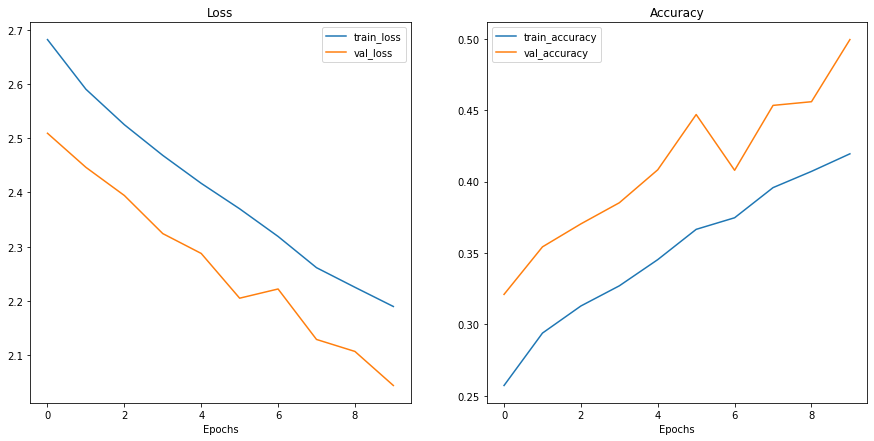

In [ ]:
loss_hist = {"train": results_rep["train_loss"], "val": results_rep["test_loss"]}
acc_hist = {"train": results_rep["train_acc"], "val": results_rep["test_acc"]}
                              
plot_loss_curves(loss_hist, acc_hist)

In [ ]:
torch.cuda.empty_cache()